In [1]:
import threading
import progressbar
import time
from progressbar import Bar, ETA, Percentage, ProgressBar, SimpleProgress
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from dataset import Dataset
from ops import *
from model import create_netD, create_netG, my_init

Using TensorFlow backend.


In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)

sess = tf.Session()
K.set_session(sess)

dataset='facades'
ngf = 64
ndf = 64
batch_size = 4
nb_epochs = 10

data = Dataset(dataset=dataset, batch_size=batch_size, thread_num=1)

(train_X, train_y) = data.get_inputs()

test_img, test_label = load_image('./datasets/%s/val/%d.jpg' % (dataset, 1))
test_img = img_shift(test_img)
test_label = img_shift(test_label)

img_shape, label_shape = data.get_shape()

image_width = img_shape[0]
image_height = img_shape[1]
input_channel = label_shape[2]
output_channel = img_shape[2]

print(img_shape, label_shape)

Batch size: 4, Thread num: 1
load dataset done
data size: 399
[256, 256, 3] [256, 256, 3]


In [3]:
print(test_img.shape, test_label.shape)

(256, 256, 3) (256, 256, 3)


In [4]:
import imp
import ops
imp.reload(ops)
from ops import *

In [5]:
import imp
import model
imp.reload(model)
from model import create_netD, create_netG, my_init

In [6]:
# Generator
# U-NET
# CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128

tmp_x = tf.placeholder(tf.float32, [batch_size, image_width, image_height, input_channel])
test_x = tf.placeholder(tf.float32, [1, image_width, image_height, input_channel])

D = create_netD(image_width, image_height, input_channel+output_channel, ndf, 3)
dec_output, generated_img, encoder_decoder = create_netG(train_X, tmp_x, ngf, 3, image_width, image_height, input_channel, output_channel, batch_size)

/Users/aviavidan/src/pix2pix/model.py:185: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding='same'
/Users/aviavidan/src/pix2pix/model.py:206: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding='same'
/Users/aviavidan/src/pix2pix/model.py:226: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding='same'
/Users/aviavidan/src/pix2pix/model.py:246: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding='same'
/Users/aviavidan/src/pix2pix/model.py:265: UserWarning: Update your `Conv2DTranspose` call to the Ke

In [7]:
# ## Objective function

loss_d = tf.reduce_mean(tf.log(D(concat(train_X, train_y)) + 1e-12)) +\
tf.reduce_mean(tf.log(1 - D(concat(train_X, dec_output)) + 1e-12))

loss_g_1 = tf.reduce_mean(tf.log(1 - D(concat(train_X, dec_output)) + 1e-12))
loss_g_2 = tf.reduce_mean(tf.abs(train_y - dec_output))
loss_g = loss_g_1 + 100. * loss_g_2


# ## Optimizer
d_lr = 1e-4
g_lr = 1e-4

train_d = tf.train.AdamOptimizer(d_lr, beta1=0.5).minimize(
    -loss_d, var_list=D.trainable_weights)

train_g = tf.train.AdamOptimizer(
    g_lr, beta1=0.5).minimize(
    loss_g, var_list=[op for l in map(lambda x: x.trainable_weights, encoder_decoder) for op in l])

In [ ]:
# initialize the model
sess.run(tf.global_variables_initializer())
last_epoch = 0

In [11]:
# Load last Checkpoint
last_chkp = tf.train.latest_checkpoint('./model/'+dataset+'/')
last_epoch = int(last_chkp.split('-')[-1])
saver.restore(sess, last_chkp)

2

In [12]:
### Initialize
nb_epochs = 1
SETPS_IN_EPOCH = data.get_size() - 1
SETPS_IN_EPOCH = 10


#tf.train.start_queue_runners(sess=sess)
data.start_threads(sess)
saver = tf.train.Saver()
mkdir('./model')
# # Training 

print('start training')
widgets = ['Train: ', Percentage(), '(', SimpleProgress(), ') ',Bar(marker='#', left='[', right=']'), ' ', ETA()]


for i in range(last_epoch, last_epoch+nb_epochs):
    ave_d = []
    ave_g = []

    pbar = ProgressBar(widgets=widgets, maxval=SETPS_IN_EPOCH)
    pbar.start()

#     for j in range(SETPS_IN_EPOCH):
    for j in range(SETPS_IN_EPOCH):
        sess.run(train_d, feed_dict={K.learning_phase(): 1})
        sess.run(train_g, feed_dict={K.learning_phase(): 1})

        loss_d_val = sess.run(loss_d, feed_dict={K.learning_phase(): 1})
        ave_d.append(loss_d_val)
        ave_g.append(sess.run(loss_g, feed_dict={K.learning_phase(): 1}))
        time.sleep(1e-6)
        pbar.update(j)
    pbar.finish()

    print("Epoch %d/%d - dis_loss: %g - gen_loss: %g" % (i+1, last_epoch+nb_epochs, np.mean(ave_d), np.mean(ave_g)))
    generated_image = sess.run(generated_img, feed_dict={tmp_x: [test_label]*4, K.learning_phase(): 1})
    save_image(generated_image[0], './output_imgs/' + dataset , i+1)
    saver.save(sess, './model/{}/model.ckpt'.format(dataset), global_step=i+1)

start training
INFO:tensorflow:Restoring parameters from ./model/facades/model.ckpt-2


Train: 100%(10 of 10) [#########################################] Time: 0:00:44


Epoch 3/1 - dis_loss: -0.0195586 - gen_loss: 31.2118


In [29]:
generated_image = sess.run(generated_img, feed_dict={tmp_x: [test_label]*4, K.learning_phase(): 1})

In [30]:
print(generated_image[0].shape, np.min(generated_image[0]), np.max(generated_image[0]))

(256, 256, 3) -0.76771426 0.56156445


In [48]:
test_label.shape
test_labels = np.array([test_label]*4)
test_labels.shape

(4, 256, 256, 3)

In [52]:
test_labels = np.array([test_label]*4)
test_d = np.concatenate((generated_image, test_labels), axis=3)
test_d.shape

(4, 256, 256, 6)

In [55]:
plt_img = (np.array(generated_image[0]) - np.min(generated_image[0])) 
plt_img /= np.max(plt_img)
plt.imshow(test_label)
plt.show()

ValueError: Floating point image RGB values must be in the 0..1 range.

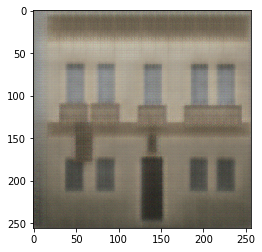

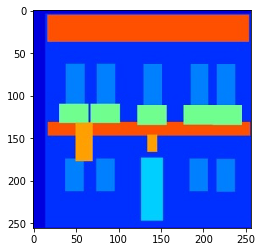

In [58]:
def plot_img(img):
    plt.imshow(np.array((img+1)*127.5, dtype=np.uint8))
    plt.show()
    
plot_img(generated_image[0])
plot_img(test_label)

In [54]:
predict = D.predict(test_d)
predict.shape

(4, 1024)

In [60]:
D.inputs

[<tf.Tensor 'conv2d_1_input:0' shape=(?, 256, 256, 6) dtype=float32>]